## Testing Bound Propogation for BNN Verification 
### Using simple 1D problem and a set of small BNNs trained with VI

In [1]:
"""
PYTHON 2.7 KERNEL
VERSION OF DEPENDANCIES:

NUMPY ------ 1.16.6
MATPLOTLIB - 2.2.3
TENSORFLOW - 1.3.0
EDWARD ----- 1.3.5
SCIPY ------ 1.1.0
SEABORN ---- 0.9.0
"""

'\nPYTHON 2.7 KERNEL\nVERSION OF DEPENDANCIES:\n\nNUMPY ------ 1.16.6\nMATPLOTLIB - 2.2.3\nTENSORFLOW - 1.3.0\nEDWARD ----- 1.3.5\nSCIPY ------ 1.1.0\nSEABORN ---- 0.9.0\n'

In [2]:
"""
Creating Dataset
"""
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Number of data points we want to use:
n_data = 50
# Range of X values
X_train = np.random.uniform(-4,4,(n_data))
# Range of noise
noise = np.random.normal(0.0,5,(n_data))
# Computed y values
y_train = [X_train[i]**3 + noise[i] for i in(range(len(X_train)))]

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


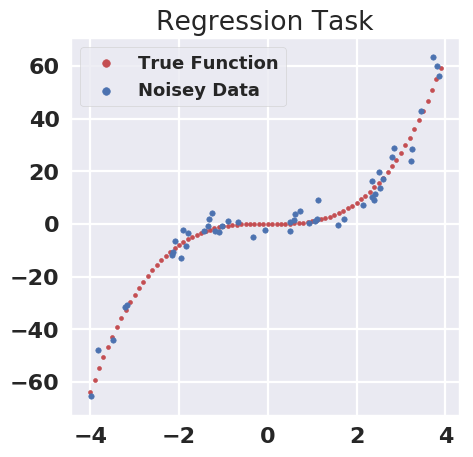

In [3]:
"""
Visualizing the dataset 
"""
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()
from matplotlib.pyplot import figure
figure(num=None, figsize=(5, 5), dpi=100)
sns.set_context("paper", rc={'axes.labelsize': 17.6,
 'axes.titlesize': 19.2,
 'font.size': 19.2,
 'grid.linewidth': 1.6,
 'legend.fontsize': 16.0,
 'lines.linewidth': 2.8,
 'lines.markeredgewidth': 0.0,
 'lines.markersize': 11.2,
 'patch.linewidth': 0.48,
 'xtick.labelsize': 16.0,
 'xtick.major.pad': 11.2,
 'xtick.major.width': 1.6,
 'xtick.minor.width': 0.8,
 'ytick.labelsize': 16.0,
 'ytick.major.pad': 11.2,
 'ytick.major.width': 1.6,
 'ytick.minor.width': 0.8}) 

sns.set_style('darkgrid')
font = {'family' : 'normal',
        'weight' : 'bold', "size":24}
matplotlib.rc('font', **font)

solution_x = [i/10.0 for i in range(-40,40) ]
solution_y = [(i/10.0)**3 for i in range(-40,40) ]
plt.title(r"Regression Task")
plt.scatter(x=solution_x, y=solution_y, c='r',s=8, label='True Function')
plt.scatter(X_train, y_train, label ='Noisey Data', s=15)

lgnd = plt.legend(scatterpoints=1, fontsize=13)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
plt.show()

In [4]:
"""
The next three are all just training the BNN
"""
from edward.models import Normal
import tensorflow as tf

X_train = X_train.reshape((-1,1))

def neural_network(x):
    h = tf.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

N = n_data  # number of data ponts
D = 1       # number of features
width = 128

# Prior Variables
W_0 = Normal(loc=tf.zeros([D, width]), scale=tf.ones([D, width]))
W_1 = Normal(loc=tf.zeros([width, 1]), scale=tf.ones([width, 1]))
b_0 = Normal(loc=tf.zeros(width), scale=tf.ones(width))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

# Posterior Variables
qW_0 = Normal(loc=tf.Variable(tf.random_normal([D, width])),
                scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, width])))) 
qb_0 = Normal(loc=tf.Variable(tf.random_normal([width])),
                scale=tf.nn.softplus(tf.Variable(tf.random_normal([width]))))
qW_1 = Normal(loc=tf.Variable(tf.random_normal([width, 1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([width, 1])))) 
qb_1 = Normal(loc=tf.Variable(tf.random_normal([1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

x = tf.cast(X_train, dtype=tf.float32)
y = Normal(loc=neural_network(x), scale=0.1 * tf.ones(N))

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
import edward as ed
y_ph = tf.placeholder(tf.float32, [N])
inference = ed.KLqp({W_0: qW_0, b_0: qb_0, W_1:qW_1, b_1:qb_1}, data={y:y_ph})
inference.initialize(n_iter=20000, n_print=200, scale={y:1.0})

In [6]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for _ in range(inference.n_iter):
    info_dict = inference.update(feed_dict={x: X_train, y_ph: y_train})
    inference.print_progress(info_dict)

20000/20000 [100%] ██████████████████████████████ Elapsed: 43s | Loss: 33626.574


In [7]:
from tqdm import trange
# Return result of posterior predictive distribution
def run_model(x, samples=100):
    sW_0 = qW_0.sample(samples).eval()
    sb_0 = qb_0.sample(samples).eval()
    sW_1 = qW_1.sample(samples).eval()
    sb_1 = qb_1.sample(samples).eval()
    y_pred = np.asarray([0.0 for i in range(len(x))])
    for i in trange(samples):
        h = tf.tanh(tf.matmul(x, sW_0[i]) + sb_0[i])
        h = tf.matmul(h, sW_1[i]) + sb_1[i]
        y_prime = tf.reshape(h, [-1]).eval()
        y_pred += y_prime
    return y_pred/float(samples)

In [8]:
from tqdm import trange
# Return what individual sampled weights give in output space
def get_all_outs(x, samples=100):
    sW_0 = qW_0.sample(samples).eval()
    sb_0 = qb_0.sample(samples).eval()
    sW_1 = qW_1.sample(samples).eval()
    sb_1 = qb_1.sample(samples).eval()
    y_pred = []
    for i in trange(samples):
        h = tf.tanh(tf.matmul(x, sW_0[i]) + sb_0[i])
        h = tf.matmul(h, sW_1[i]) + sb_1[i]
        y_prime = tf.reshape(h, [-1]).eval()
        y_pred.append(y_prime[0])
    return y_pred

In [9]:
y_pred = run_model(X_train.astype('float32'))

100%|██████████| 100/100 [00:06<00:00, 16.40it/s]


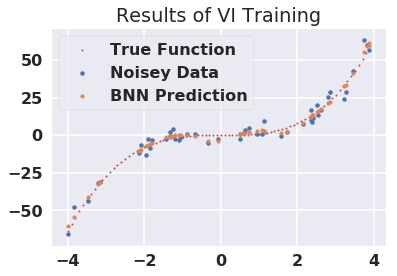

In [10]:
plt.title("Results of VI Training")
plt.scatter(x=solution_x, y=solution_y, c='r',s=2, label='True Function')
plt.scatter(X_train, y_train, label ='Noisey Data', s=15)
plt.scatter(x=X_train, y=y_pred, label='BNN Prediction', s=12)
plt.legend()
plt.show()

In [11]:
# Lets zoom in at a point a zero...
y_pred = get_all_outs(np.asarray([[0.0]]).astype('float32'))

100%|██████████| 100/100 [00:08<00:00, 12.13it/s]


100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


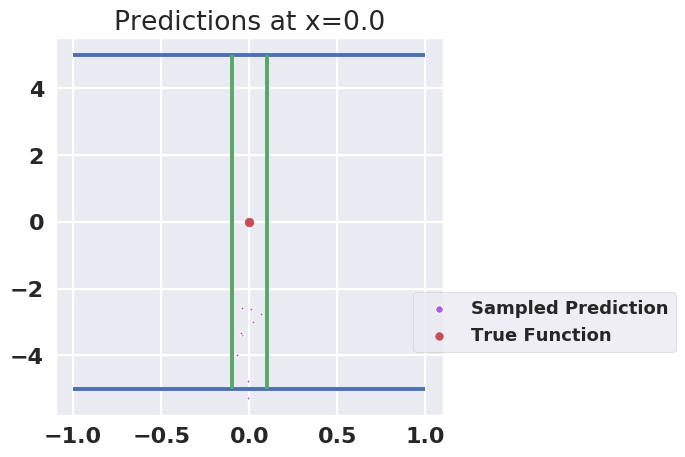

In [13]:
figure(num=None, figsize=(5, 5), dpi=100)
sns.set_context("paper", rc={'axes.labelsize': 17.6,
 'axes.titlesize': 19.2,
 'font.size': 19.2,
 'grid.linewidth': 1.6,
 'legend.fontsize': 16.0,
 'lines.linewidth': 2.8,
 'lines.markeredgewidth': 0.0,
 'lines.markersize': 11.2,
 'patch.linewidth': 0.48,
 'xtick.labelsize': 16.0,
 'xtick.major.pad': 11.2,
 'xtick.major.width': 1.6,
 'xtick.minor.width': 0.8,
 'ytick.labelsize': 16.0,
 'ytick.major.pad': 11.2,
 'ytick.major.width': 1.6,
 'ytick.minor.width': 0.8}) 

sns.set_style('darkgrid')
font = {'family' : 'normal',
        'weight' : 'bold', "size":24}
matplotlib.rc('font', **font)


plt.title("Predictions at x=0.0")
xs = [np.random.normal(0,0.05) for i in range(50)]
y_pred = []
for x in xs:
    inp = np.asarray([[x]]).astype('float32').transpose()
    y = run_model(inp, samples=1)
    y_pred.append(y)
#print y_pred
sns.scatterplot(x=xs, y=y_pred, label ='Sampled Prediction',color="#a95fde", s=5)
plt.hlines(5, -1, 1, color='b')
plt.hlines(-5, -1, 1, color='b')

plt.vlines(0.1, -5, 5, color='g')
plt.vlines(-0.1, -5, 5, color='g')

plt.scatter(x=[0.0], y=[0.0], c='r',s=39, label='True Function')
lgnd = plt.legend(bbox_to_anchor=(.9, 0.35), scatterpoints=1, fontsize=13)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
plt.show()

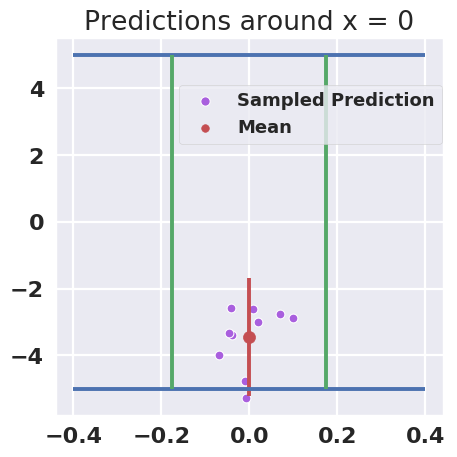

In [14]:
figure(num=None, figsize=(5, 5), dpi=100)
sns.set_context("paper", rc={'axes.labelsize': 17.6,
 'axes.titlesize': 19.2,
 'font.size': 19.2,
 'grid.linewidth': 1.6,
 'legend.fontsize': 16.0,
 'lines.linewidth': 2.8,
 'lines.markeredgewidth': 0.0,
 'lines.markersize': 11.2,
 'patch.linewidth': 0.48,
 'xtick.labelsize': 16.0,
 'xtick.major.pad': 11.2,
 'xtick.major.width': 1.6,
 'xtick.minor.width': 0.8,
 'ytick.labelsize': 16.0,
 'ytick.major.pad': 11.2,
 'ytick.major.width': 1.6,
 'ytick.minor.width': 0.8}) 

sns.set_style('darkgrid')
font = {'family' : 'normal',
        'weight' : 'bold', "size":24}
matplotlib.rc('font', **font)

sns.scatterplot(x=xs, y=y_pred, label ='Sampled Prediction',color="#a95fde", s=40)

plt.scatter(x=np.mean(xs), y=np.mean(y_pred), label='Mean', color="r", s=75)
plt.vlines(x=np.mean(xs), ymin=np.mean(y_pred)-2*np.std(y_pred), 
           ymax=np.mean(y_pred)+2*np.std(y_pred), color='r')

plt.hlines(5, -0.4, 0.4, color='b')
plt.hlines(-5, -0.4, 0.4, color='b')

plt.vlines(0.175, -5, 5, color='g')
plt.vlines(-0.175, -5, 5, color='g')

#plt.scatter(x=[0.0], y=[0.0], c='r',s=39, label='True Function')
plt.title("Predictions around x = 0")
lgnd = plt.legend(bbox_to_anchor=(1.02, 0.9), scatterpoints=1, fontsize=13)
lgnd.legendHandles[0]._sizes = [45]
lgnd.legendHandles[1]._sizes = [30]
plt.show()

In [15]:
#Save function
mW_0 = qW_0.mean().eval(); dW_0 = qW_0.stddev().eval()
mb_0 = qb_0.mean().eval(); db_0 = qb_0.stddev().eval()
mW_1 = qW_1.mean().eval(); dW_1 = qW_1.stddev().eval()
mb_1 = qb_1.mean().eval(); db_1 = qb_1.stddev().eval()

np.savez_compressed("VIMODEL.net", [mW_0, mb_0, mW_1, mb_1,
                                    dW_0, db_0, dW_1, db_1], 
                                   ['mw0', 'mb0', 'mw1', 'mb1',
                                    'dw0', 'db0', 'dw1', 'db1'])